# Data Augmentation using Unsupervised Style Transfer 

In [1]:
import itertools
import os
import sys
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn

In [114]:
from style_transfer import Tokenizer, get_dataset, translate
sys.path.append('../deep-latent-sequence-model/src')
from data_utils import DataUtil
from utils import reorder
os.chdir('/home/przemyslaw/text-style-transfer/deep-latent-sequence-model')

model_dir = '../deep-latent-sequence-model/outputs_yelp_/yelp_wd0.0_wb0.0_ws0.0_an3_pool5_klw0.1_lr0.001_t0.01_lm_bt_hard_avglen'
model_path = os.path.join(model_dir, 'model.pt')
model = torch.load(model_path).eval()

tokenizer = Tokenizer(model.data.src_i2w)

In [115]:
texts = ['I hate this place', 'This is very cool', 'I love it', 'I hate it', 'I would definitely do it again']
target_styles = [1, 0, 0, 1, 0]
translate(model, tokenizer, texts, target_styles)

/home/przemyslaw/.local/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


['love this place .', 'unbelievable .', 'gross .', 'love it !', 'gross .']

## Loading setiment data from yelp

In [136]:
np.random.seed(42)

yelp_path = '../deep-latent-sequence-model/data/yelp'
yelp_train = get_dataset('yelp', 'train')
yelp_dev = get_dataset('yelp', 'dev')
print(yelp_train.shape)
yelp_train.head()

(444101, 2)


,text,attr
0,i was sadly mistaken .,negative
1,"so on to the hoagies , the italian is general ...",negative
2,minimal meat and a ton of shredded lettuce .,negative
3,nothing really special & not worthy of the $ _...,negative
4,"second , the steak hoagie , it is atrocious .",negative


In [137]:
target_map = {
    'negative': 1,
    'positive': 0
}

label_map = {
    'negative': 0,
    'positive': 1
}

In [138]:
for _, row in yelp_train.sample(20).iterrows():
    text, attr = row['text'], row['attr']
    translation = translate(model, tokenizer, text, target_map[attr], beam_size=10)[0]
    print(f'({attr})', text, '--->', translation)

/home/przemyslaw/.local/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(negative) first off , the colors were outdated and looked watered down . ---> incredible food !
(positive) great spot ! ---> _num_ stars .
(negative) i do n't understand why this place is so popular . ---> i love this place and this place is so popular .
(positive) great local bar ! ---> big disappointment !
(negative) the sink looks like it has n't been wiped down in months . ---> honest !
(negative) false advertisement . ---> refreshing .
(positive) would recommend any location . ---> would not recommend them .
(positive) chicago pizza rocks ! ---> pizza sucks !
(positive) especially for a smaller production . ---> annoying .
(negative) what level of hell is this dive ? ---> solid !
(positive) a great shop , great products , great service . ---> no call .
(positive) you can even find rare records here too . ---> shame .
(positive) great service , nice road bikes . ---> horrible service .
(negative) such a shame . ---> such a gem .
(positive) food comes quickly and is always fantasti

## Training a model
Should we use something simple and easy like CNN or rather something more powerful like Bert?

* CNN: lightweight, authors of the paper used it, doesn't require special tokenization, probably worse accuracy
* Bert: more complicated, requires a lot of GPU memory, requires special tokenizer (different than the one used in style transfer model), better accuracy

I choose CNN, for Bert I would probably pretrain style transfer model with different tokenizer, so that transfered sentences make sence and don't have `<unk>` tokens. I will probably do it anyway, but not now. This is supposed to be simple. 

Should I use keras or torch?
* keras: for noobs, easy to use if you don't require a lot of training loop customization
* pytorch: more complicated, but you can do a lot with it

I choose keras for now, it's very easy to create a simple classifier with it. 

### Data 
The only difficulty will be to create dataset to provide as an input. We have to tokenize everything and take care of the padding.

In [139]:
MAX_LEN = 20

In [140]:
x_train = [tokenizer.tokenize(text, padding=MAX_LEN) for text in yelp_train['text'].values]
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN)
y_train = np.array([label_map[attr] for attr in yelp_train['attr'].values])

x_dev = [tokenizer.tokenize(text, padding=MAX_LEN) for text in yelp_dev['text'].values]
x_dev = tf.keras.preprocessing.sequence.pad_sequences(x_dev, maxlen=MAX_LEN)
y_dev = np.array([label_map[attr] for attr in yelp_dev['attr'].values])

In [141]:
# Building the CNN Model
sentiment_model = tf.keras.Sequential()      # initilaizing the Sequential nature for CNN model
sentiment_model.add(tf.keras.layers.Embedding(len(tokenizer), 32, input_length=MAX_LEN))
sentiment_model.add(tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
sentiment_model.add(tf.keras.layers.MaxPooling1D())
sentiment_model.add(tf.keras.layers.Flatten())
sentiment_model.add(tf.keras.layers.Dense(250, activation='relu'))
sentiment_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [142]:
sentiment_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 20, 32)            308896    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 20, 32)            3104      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 10, 32)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 250)               80250     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 251       
Total params: 392,501
Trainable params: 392,501
Non-trainable params: 0
_______________________________________________

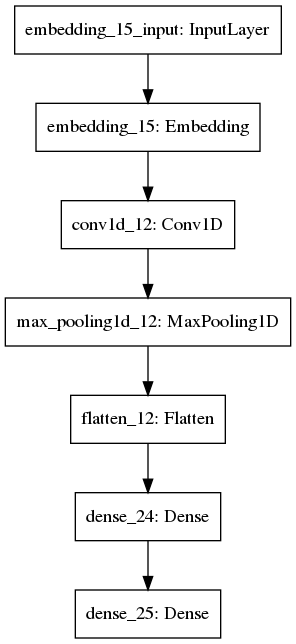

In [143]:
sentiment_model.summary()
tf.keras.utils.plot_model(sentiment_model)

In [144]:
history = sentiment_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), batch_size=64, epochs=5, shuffle=True)

Epoch 1/5
6940/6940 [==============================] - 46s 7ms/step - loss: 0.0868 - accuracy: 0.9674 - auc: 0.9946 - val_loss: 0.0653 - val_accuracy: 0.9771 - val_auc: 0.9966
Epoch 2/5
6940/6940 [==============================] - 47s 7ms/step - loss: 0.0512 - accuracy: 0.9822 - auc: 0.9977 - val_loss: 0.0613 - val_accuracy: 0.9792 - val_auc: 0.9968
Epoch 3/5
6940/6940 [==============================] - 44s 6ms/step - loss: 0.0389 - accuracy: 0.9868 - auc: 0.9984 - val_loss: 0.0630 - val_accuracy: 0.9792 - val_auc: 0.9965
Epoch 4/5
6940/6940 [==============================] - 43s 6ms/step - loss: 0.0307 - accuracy: 0.9899 - auc: 0.9988 - val_loss: 0.0678 - val_accuracy: 0.9787 - val_auc: 0.9956
Epoch 5/5
6940/6940 [==============================] - 47s 7ms/step - loss: 0.0239 - accuracy: 0.9922 - auc: 0.9992 - val_loss: 0.0748 - val_accuracy: 0.9778 - val_auc: 0.9950
